In [965]:
%load_ext autoreload
%autoreload 2

from stanley_appex.estimation import *
from stanley_appex.plotting import *
from stanley_appex.utils import *
from stanley_appex.generate_data import *
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


N_traj 41


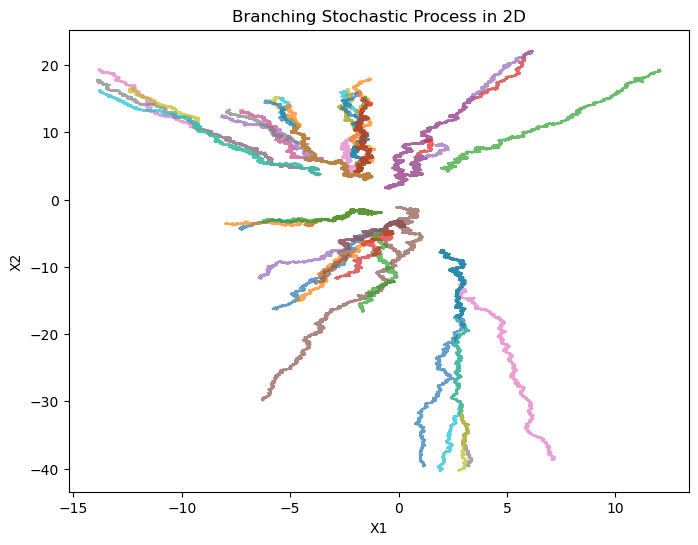

In [788]:
d = 2
A = np.array([[1, 0.1], 
              [-0.1, 1]])
# A = np.array([1.0])

G = np.array([[1, 0.0], 
              [0.0, 1]])
# G = np.array([1.0])

H = G@G.T

# lambda_func = lambda X: 1.3 * np.exp(-np.linalg.norm(X))  # Decaying branching rate
lambda_func = lambda X: 1 # 1.0 # 1.0 # Constant branching rate

N_init = 10
X0 = np.random.multivariate_normal([0, 0], np.diag([10, 10]), N_init) # np.random.normal(0, 1, (N_init, A.shape[1]))
# X0 = np.random.normal(0, 1, (N_init))
process = BranchingStochasticProcess(A, G, X0, lambda_func, dt=0.0001, T=1.5, N_traj=10)
# process = BranchingStochasticProcess(A, G, X0, no_branch_lambda_func, dt=0.0001, T=2.0, N_traj=10)
process.simulate(X0)
print("N_traj", process.N_traj)
# print(process.lineage_tree)
process.plot_trajectories(downsample=1)


{}


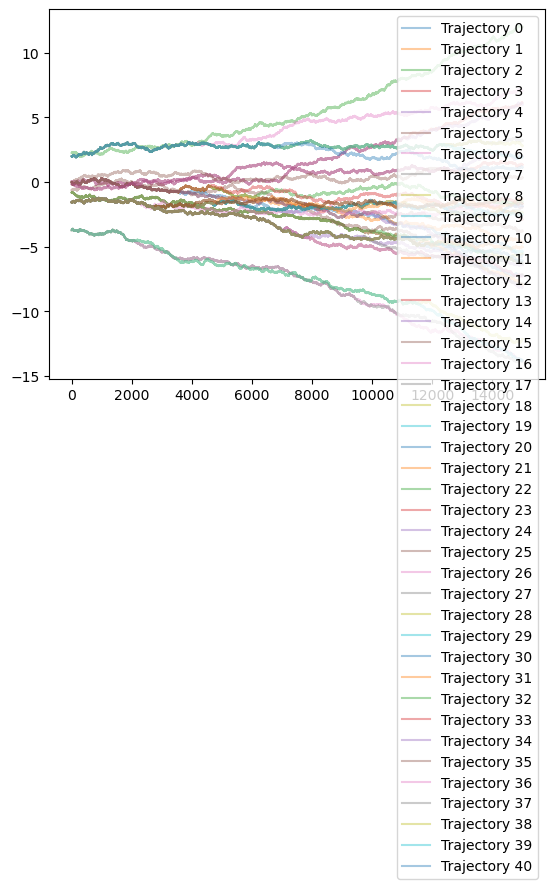

In [968]:
print(process.lineage)
for i in range(process.N_traj):
    plt.plot(process.trajectories[i, :, 0].T, label=f"Trajectory {i}", alpha=0.4);
plt.legend()

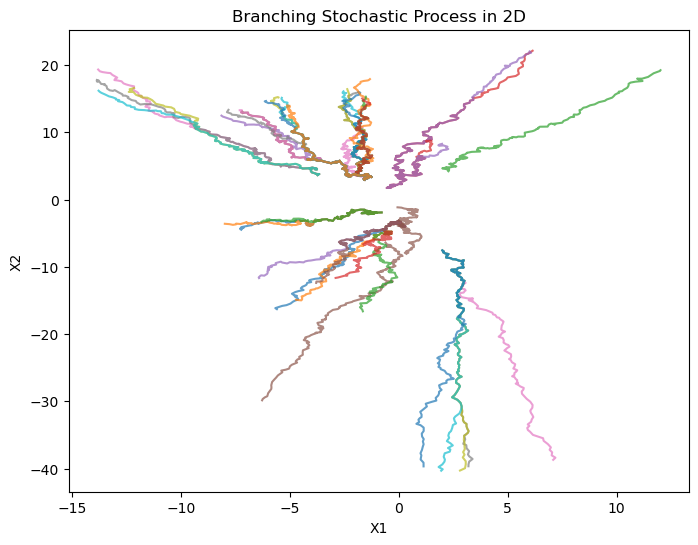

In [969]:
downsample_rate = 100

process.plot_trajectories(downsample=downsample_rate)

In [971]:
len(xs_data)

151

In [978]:
# xs_data: (N, N_traj, d)
# ts_data: (N,)

ts_data = process.ts[::downsample_rate]
xs_data = process.marginals(downsample_rate=downsample_rate)

xs_data = marginals(apply_permutation(process.trajectories[:, :-1:downsample_rate, :]))


print("N traj", process.N_traj, "N time steps", ts_data.shape[0])

# xs_data = process.trajectories.transpose((1, 0, 2))[::downsample_rate]
A_mle_all_data = A_mle(process.trajectories[:, :-1, :], process.ts)
print("A_mle:\n", A_mle_all_data)
print("A_mle_downsampled:\n", A_mle(process.trajectories[:, :-1:downsample_rate, :], process.ts[::downsample_rate]))
print("H_mle:\n", H_mle(process.trajectories, process.ts, A))
print("H_mle downsampled:\n", H_mle(process.trajectories[:, ::downsample_rate, :], process.ts[::downsample_rate], A))
print("A_mle downsampled permuted:\n", A_mle(apply_permutation(process.trajectories[:, :-1:downsample_rate, :]), process.ts[::downsample_rate]))
print("A:\n", A)
print("H:\n", H)



# print(A_mle(process.trajectories, process.ts))
# print(H_mle(process.trajectories, process.ts, A))

A_guess = A # np.eye(2) # A
H_guess = G@G.T # np.eye(2) # G@G.T
As, Hs, Pis = appex_rectangle(xs_data, ts_data, A_guess, H_guess, N_sample=process.N_traj*10, tol=1e-5, maxiters=30, print_out=25, save_coupling=True)
A_est = As[-1]
H_est = Hs[-1]
Pi_est = Pis[-1]
print("A_est:\n", A_est)
print("H_est:\n", H_est)

N traj 41 N time steps 150
A_mle:
 [[ 0.959  0.117]
 [-0.068  1.029]]
A_mle_downsampled:
 [[ 0.957  0.113]
 [-0.079  1.015]]
H_mle:
 [[1.001 0.002]
 [0.002 0.996]]
H_mle downsampled:
 [[1.02  0.005]
 [0.005 1.008]]
A_mle downsampled permuted:
 [[-72.542   2.628]
 [ -2.533 -98.053]]
A:
 [[ 1.   0.1]
 [-0.1  1. ]]
H:
 [[1. 0.]
 [0. 1.]]
iteration 0, running tolerance 1.4212670403551897
iteration 25, running tolerance 0.024295310095851487
A_est:
 [[ 0.952  0.105]
 [-0.074  1.007]]
H_est:
 [[1.07  0.005]
 [0.005 0.975]]


In [979]:
def downsample(xs, ts, downsample_rate):
    return xs[:, ::downsample_rate, :], ts[::downsample_rate]

xs_data_downsampled, ts_data_downsampled = downsample(process.trajectories, process.ts, downsample_rate)

In [980]:
branch_times_data = np.array(process.branch_times) // downsample_rate
branch_times_data

array([ 20,  22,  25,  35,  35,  38,  40,  45,  46,  60,  67,  69,  75,
        94,  95,  97,  97,  98, 110, 113, 114, 118, 121, 123, 124, 126,
       136, 138, 139, 146, 147])

A mle error 0.06163817529992776
H mle error 0.005308652036680317
A algorithm error 0.05558327662569079
H algorithm error 0.07445218424069265


/var/folders/zr/tnch39_n5hx8s_zsx1gqggch0000gn/T/ipykernel_88265/3736519321.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(A_errors), label="A error")
/var/folders/zr/tnch39_n5hx8s_zsx1gqggch0000gn/T/ipykernel_88265/3736519321.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(H_errors), label="H error")


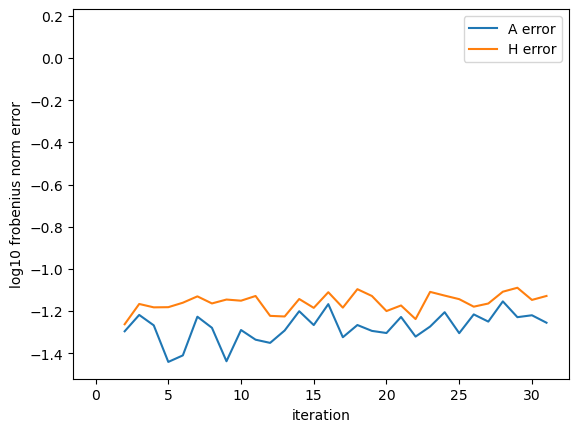

In [983]:
A_mle_all_data = A_mle(process.trajectories[:, :-1, :], process.ts)
H_mle_all_data = H_mle(process.trajectories[:, :-1, :], process.ts, A)
print("A mle error", np.linalg.norm(A_mle_all_data - A, ord="fro"))
print("H mle error", np.linalg.norm(H_mle_all_data - H, ord="fro"))

print("A algorithm error", np.linalg.norm(A_est - A, ord="fro"))
print("H algorithm error", np.linalg.norm(H_est - H, ord="fro"))

A_errors, H_errors = estimation_error(As, A, Hs, H)
plt.plot(np.log10(A_errors), label="A error")
plt.plot(np.log10(H_errors), label="H error")
plt.ylabel('log10 frobenius norm error')
plt.xlabel('iteration')
plt.legend()

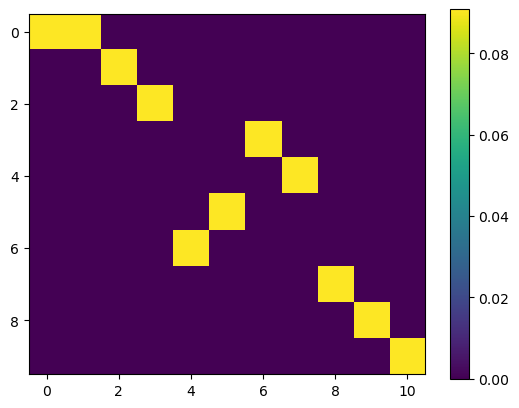

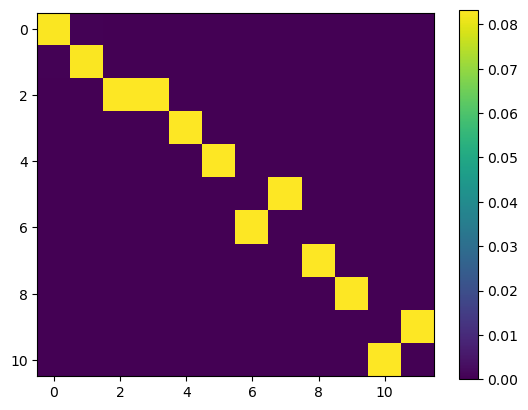

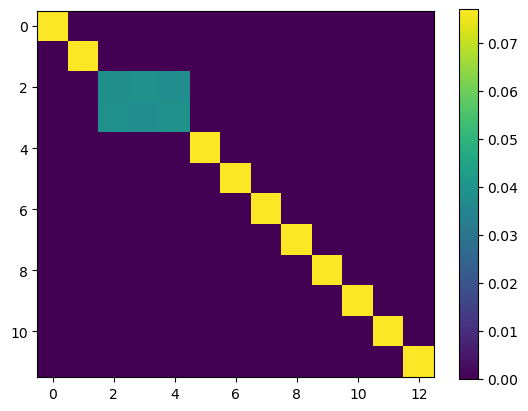

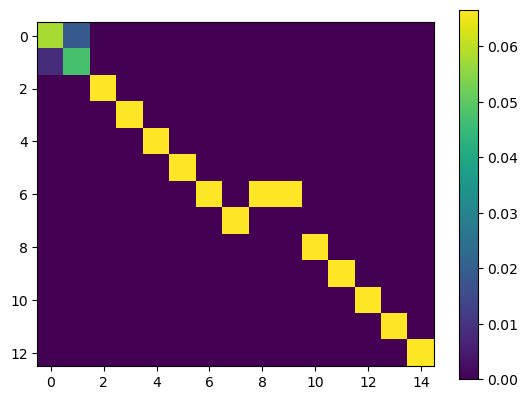

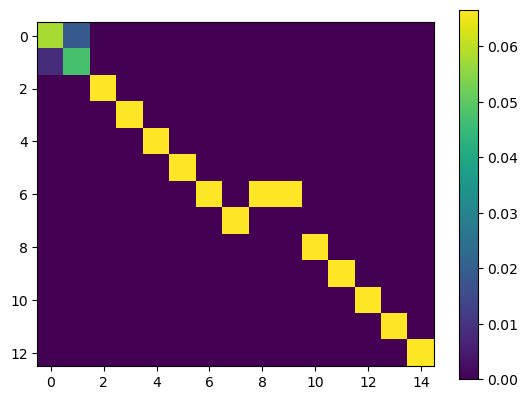

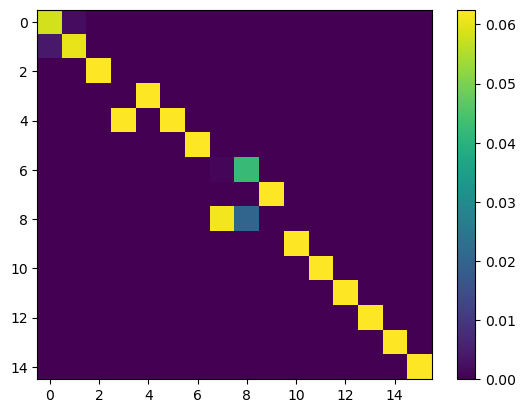

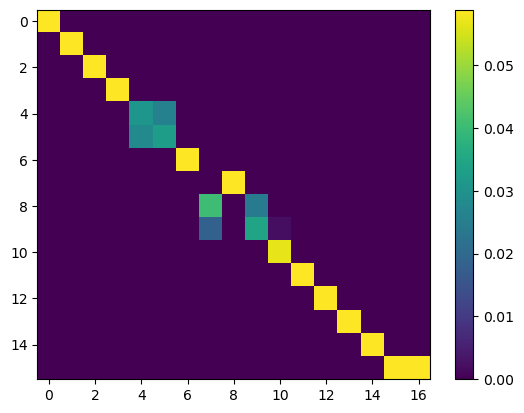

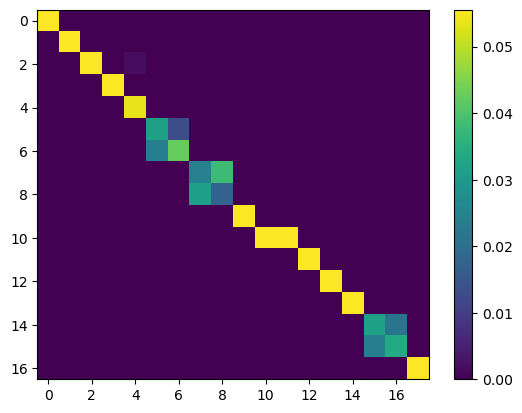

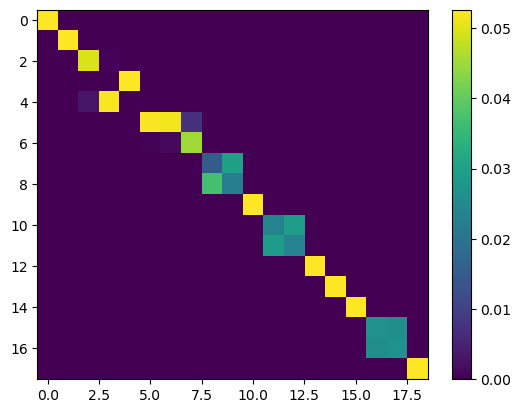

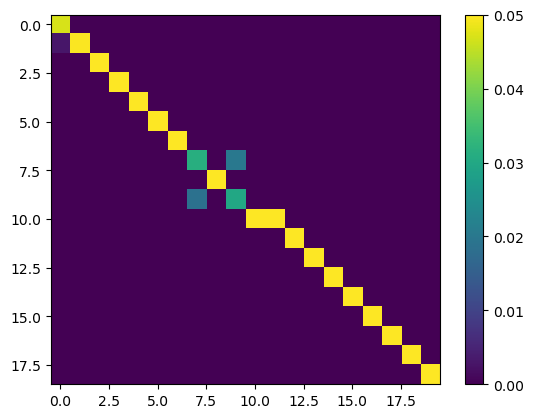

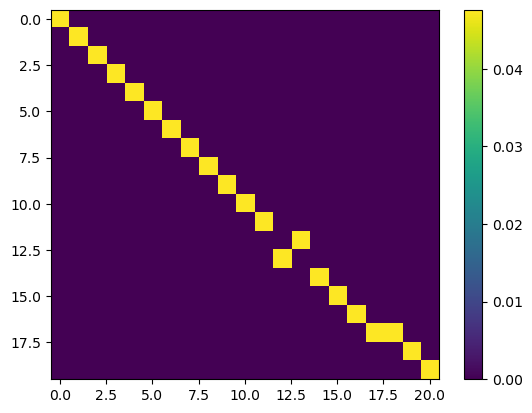

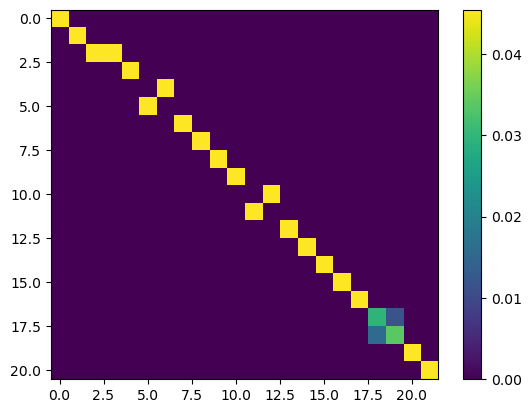

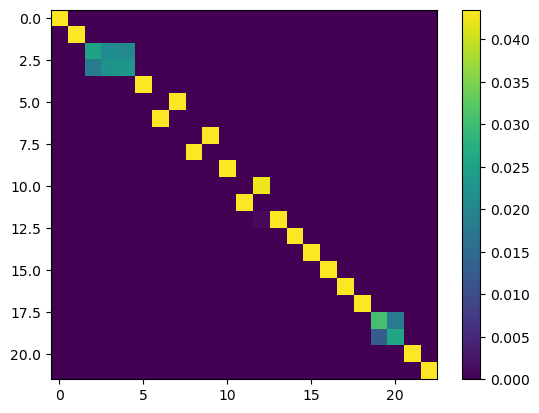

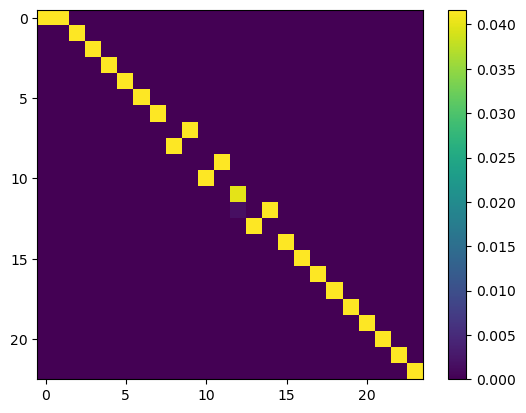

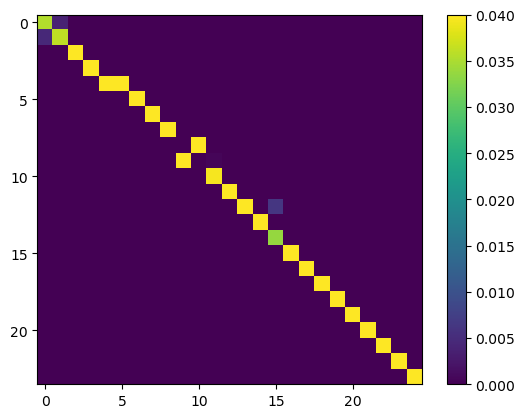

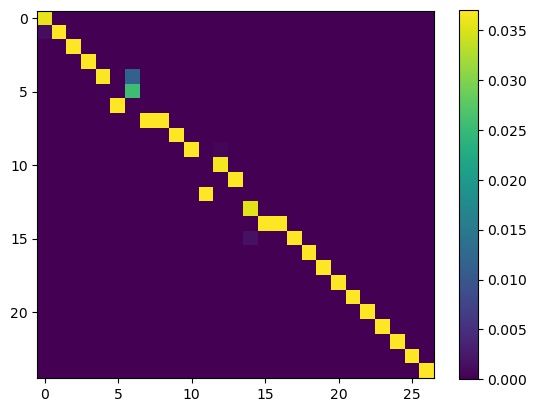

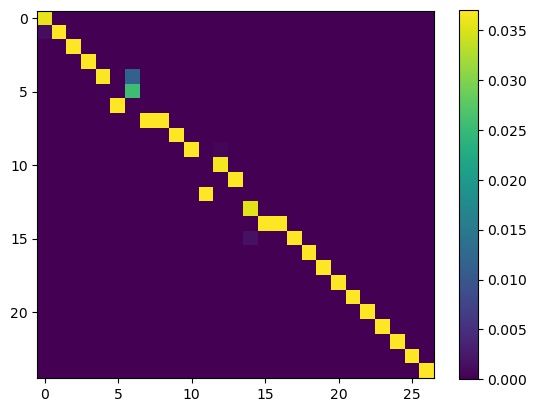

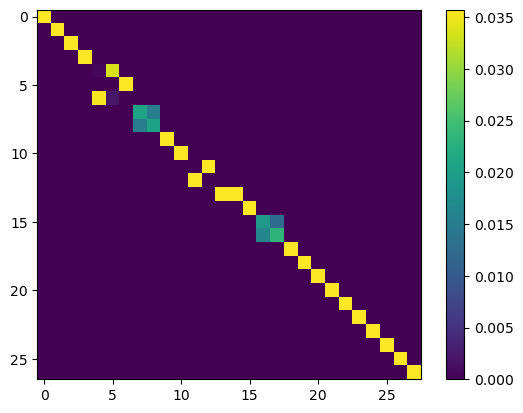

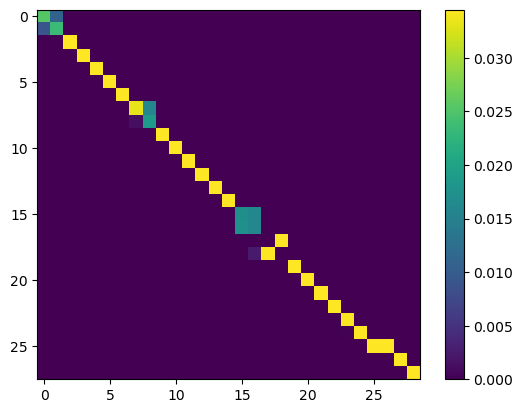

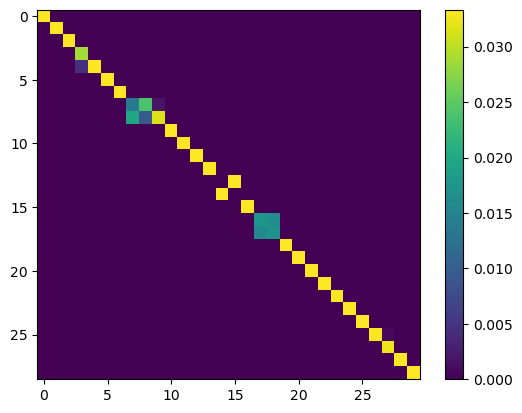

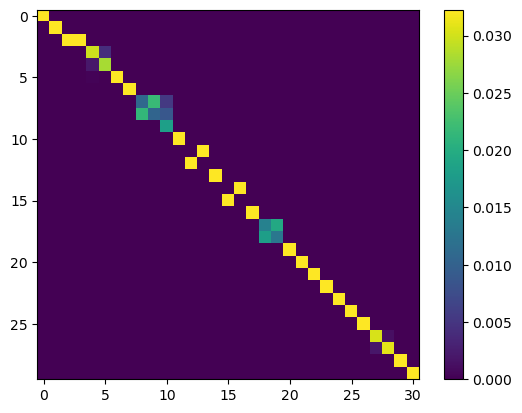

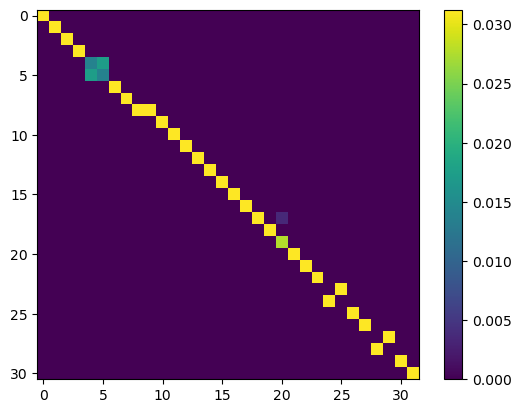

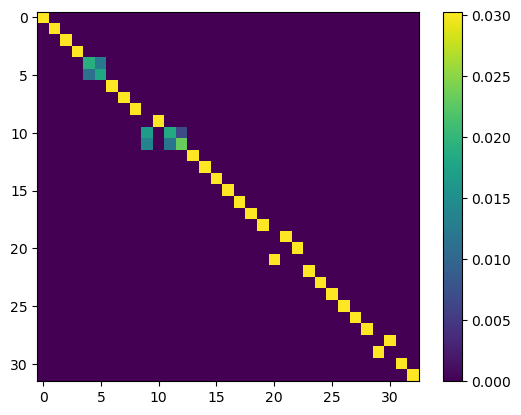

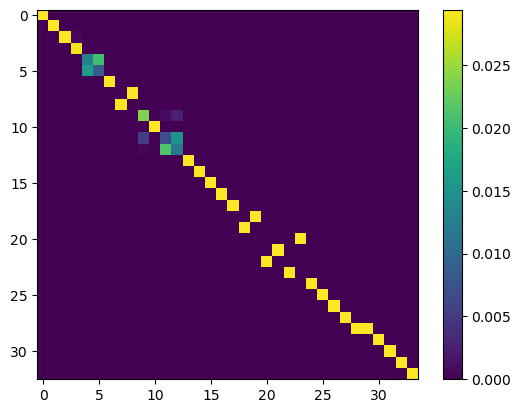

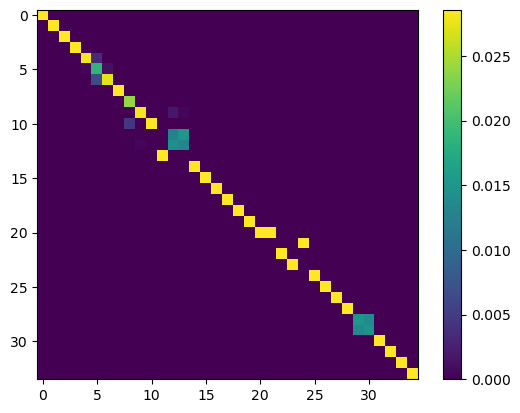

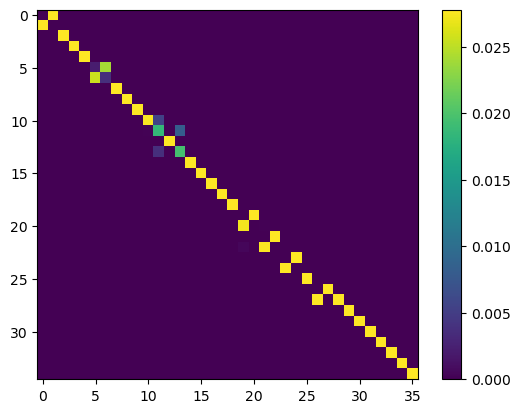

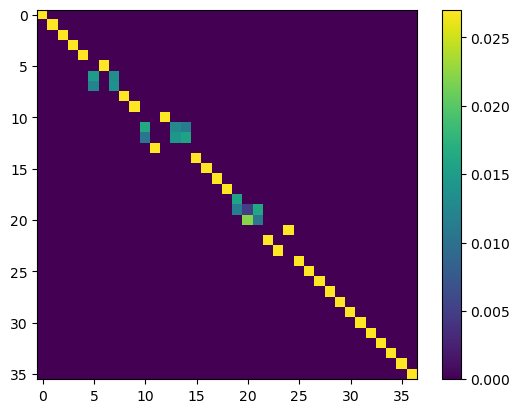

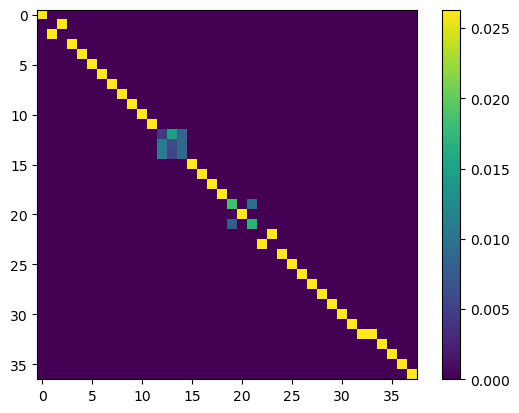

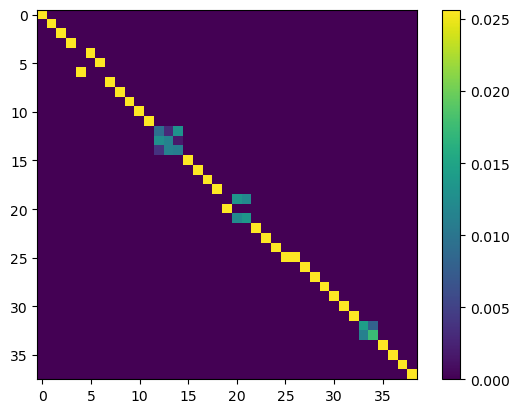

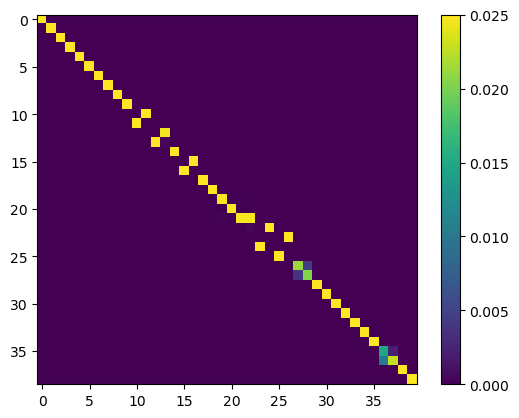

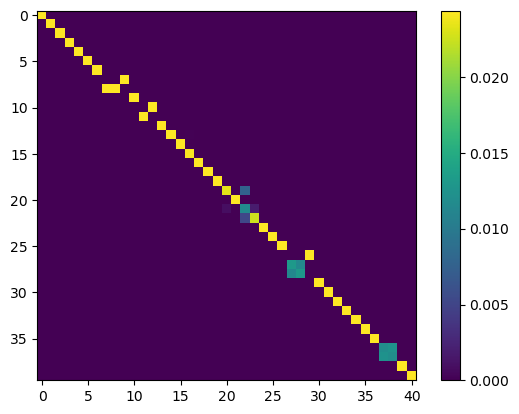

[(<matplotlib.image.AxesImage at 0x36c9c1ab0>,
  None),
 (<matplotlib.image.AxesImage at 0x36b3f5b40>,
  None),
 (<matplotlib.image.AxesImage at 0x36b07d060>,
  None),
 (<matplotlib.image.AxesImage at 0x36a8e63e0>,
  None),
 (<matplotlib.image.AxesImage at 0x36a63f2b0>,
  None),
 (<matplotlib.image.AxesImage at 0x36a2c6740>,
  None),
 (<matplotlib.image.AxesImage at 0x369f458d0>,
  None),
 (<matplotlib.image.AxesImage at 0x369de63b0>,
  None),
 (<matplotlib.image.AxesImage at 0x369c842e0>,
  None),
 (<matplotlib.image.AxesImage at 0x3593ea9b0>,
  None),
 (<matplotlib.image.AxesImage at 0x35e12ff40>,
  None),
 (<matplotlib.image.AxesImage at 0x36bd8edd0>,
  None),
 (<matplotlib.image.AxesImage at 0x36b887010>,
  None),
 (<matplotlib.image.AxesImage at 0x36b6a0ca0>,
  None),
 (<matplotlib.image.AxesImage at 0x36b5a1150>,
  None),
 (<matplotlib.image.AxesImage at 0x36c947d30>,
  None),
 (<matplotlib.image.AxesImage at 0x36ae33490>,
  None),
 (<matplotlib.image.AxesImage at 0x35e49cca0>,
 

In [984]:
[(plt.imshow(Pi_est[branch_idx]), plt.colorbar(), plt.show()) for branch_idx in branch_times_data]
# plt.imshow(Pi_est[downsample_branch_idx[idx]- 10]), plt.show()
# plt.imshow(Pi_est[1][:, :]), plt.show()


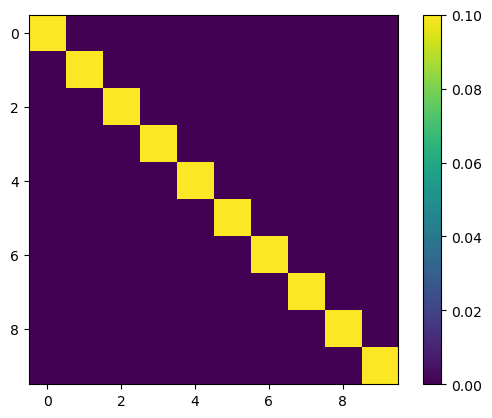

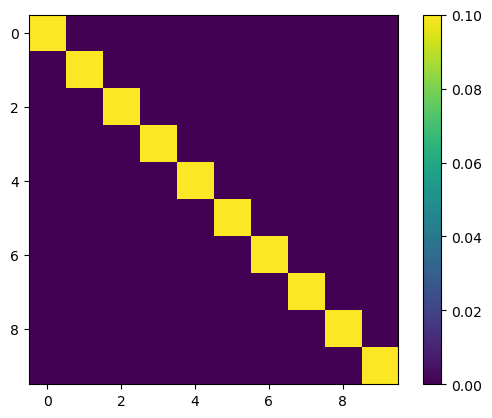

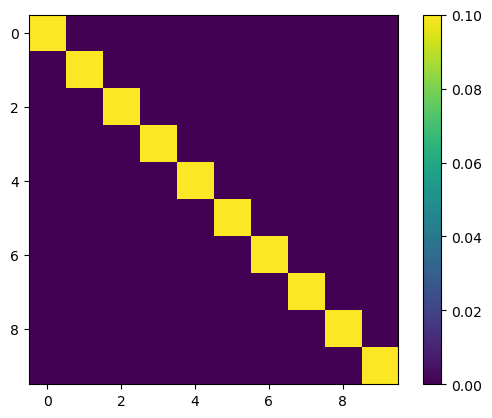

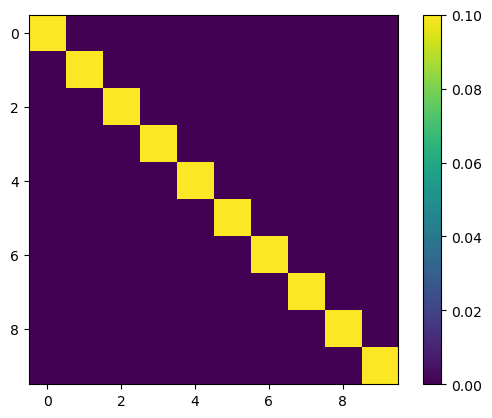

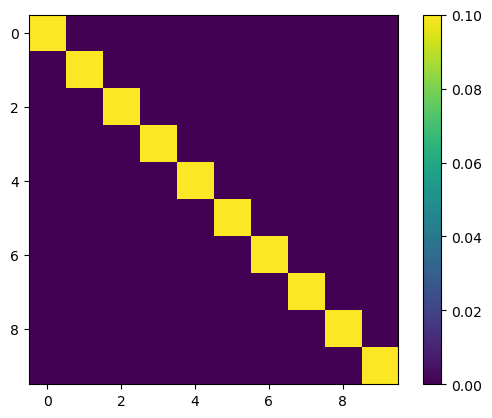

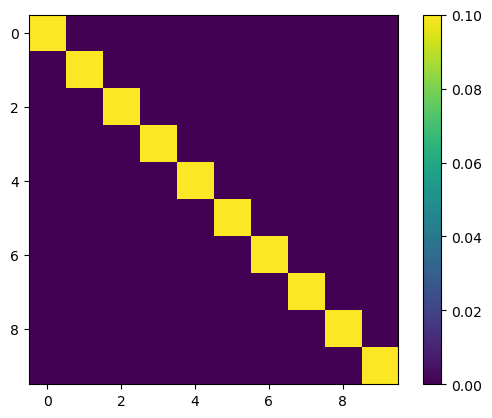

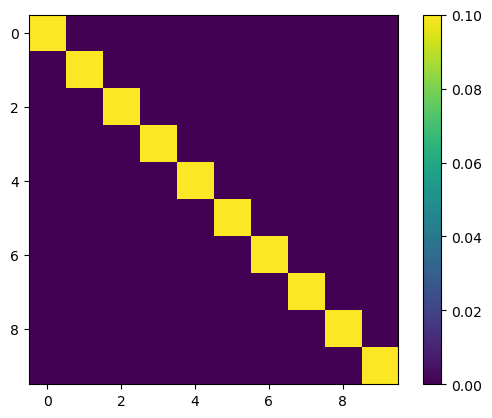

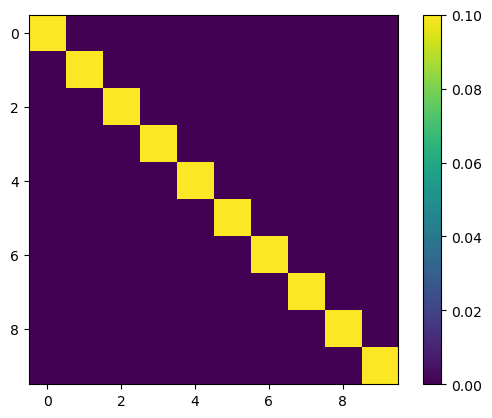

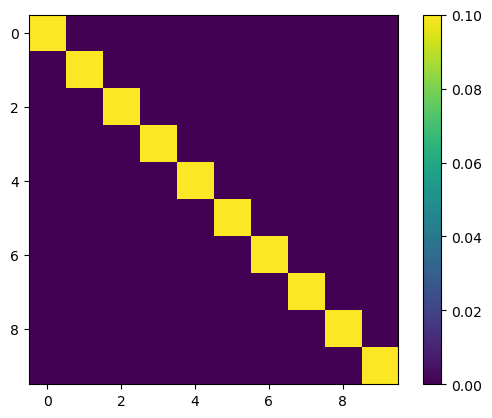

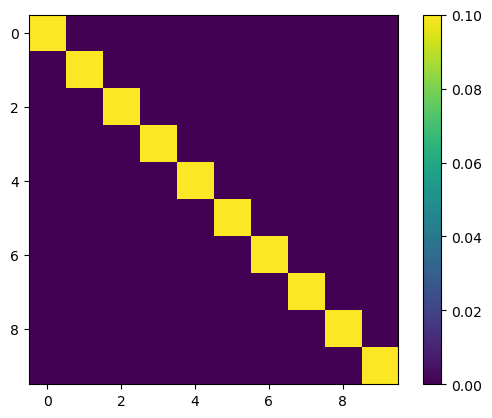

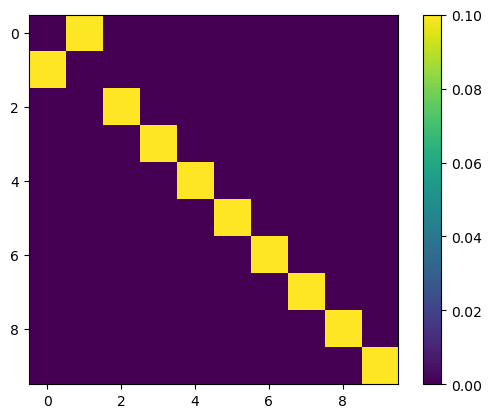

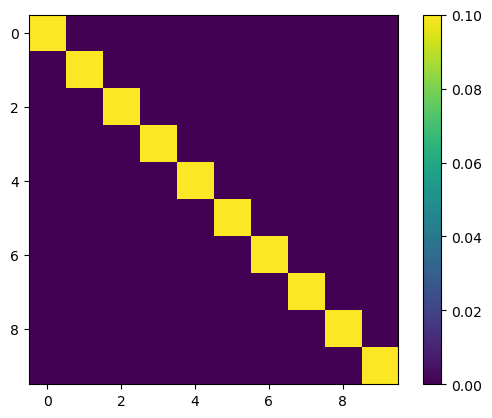

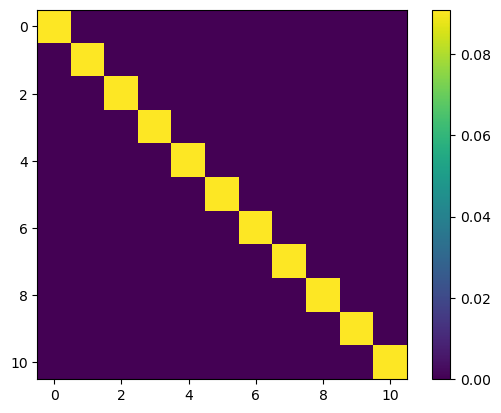

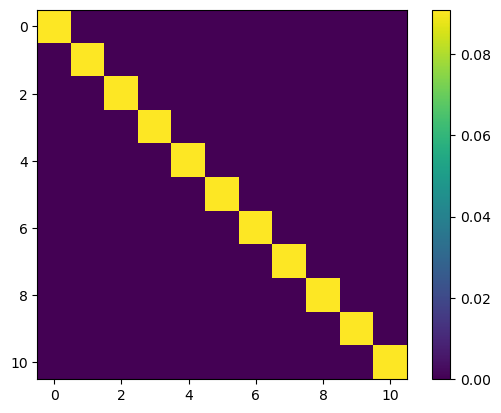

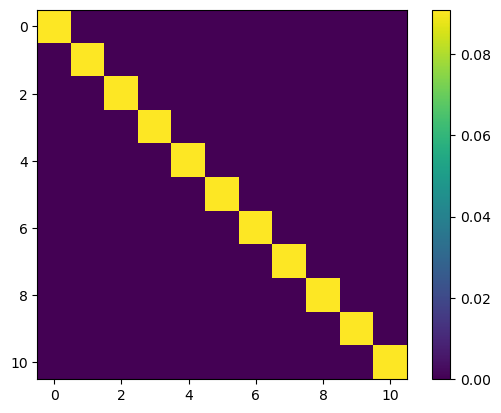

[(<matplotlib.image.AxesImage at 0x30fdd1540>,
  None),
 (<matplotlib.image.AxesImage at 0x30fe8a6e0>,
  None),
 (<matplotlib.image.AxesImage at 0x332263ac0>,
  None),
 (<matplotlib.image.AxesImage at 0x334d09fc0>,
  None),
 (<matplotlib.image.AxesImage at 0x334dc2bc0>,
  None),
 (<matplotlib.image.AxesImage at 0x334e70850>,
  None),
 (<matplotlib.image.AxesImage at 0x334f49d50>,
  None),
 (<matplotlib.image.AxesImage at 0x334ff6350>,
  None),
 (<matplotlib.image.AxesImage at 0x3358aabf0>,
  None),
 (<matplotlib.image.AxesImage at 0x335956080>,
  None),
 (<matplotlib.image.AxesImage at 0x335a31630>,
  None),
 (<matplotlib.image.AxesImage at 0x358731000>,
  None),
 (<matplotlib.image.AxesImage at 0x335b96f80>,
  None),
 (<matplotlib.image.AxesImage at 0x335c726b0>,
  None),
 (<matplotlib.image.AxesImage at 0x335d25000>,
  None)]

In [773]:
[(plt.imshow(Pi_est[i]), plt.colorbar(), plt.show()) for i in range(0, len(Pi_est), 10)]

13 15


Text(0.5, 1.0, 'Coupling')

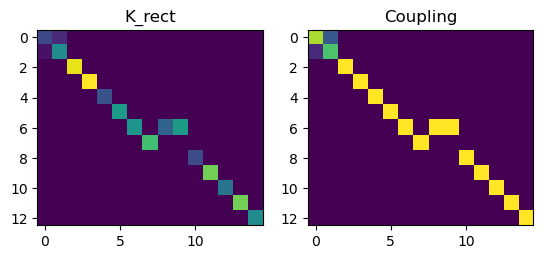

In [985]:
idx=branch_times_data[3]
ticurr, tifuture = idx, idx+1
t_curr, t_future = ts_data[ticurr], ts_data[tifuture]
x = np.array(xs_data[ticurr])
y = np.array(xs_data[tifuture])
K_rect = kernel_vec(x, y, t_curr, t_future, A, H)

N_curr = K_rect.shape[0]
N_future = K_rect.shape[1]
print(N_curr, N_future)
mu = np.ones(N_curr) / N_curr
nu = np.ones(N_future) / N_future
coupling = OT_sinkhorn(mu, nu, K_rect, maxiter=100, stopThr=1e-1, epsilon=np.inf)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(K_rect)
axs[0].set_title("K_rect")
axs[1].imshow(coupling)
axs[1].set_title("Coupling")


A: [[ 1.   0.1]
 [-0.1  1. ]] 
 A_est: [[ 0.952  0.105]
 [-0.074  1.007]]
H: [[1. 0.]
 [0. 1.]] 
 H_est [[1.07  0.005]
 [0.005 0.975]]
N_traj 41
ts 1.21


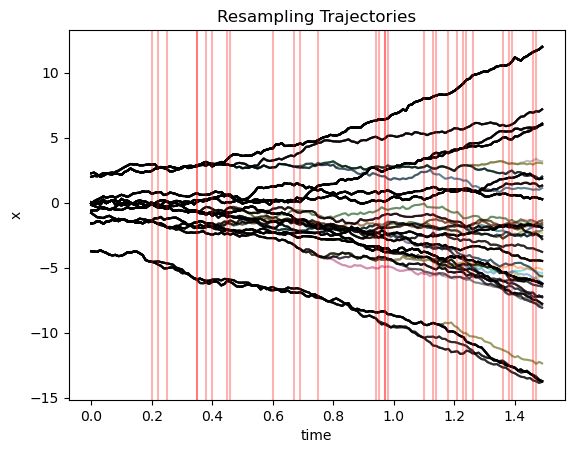

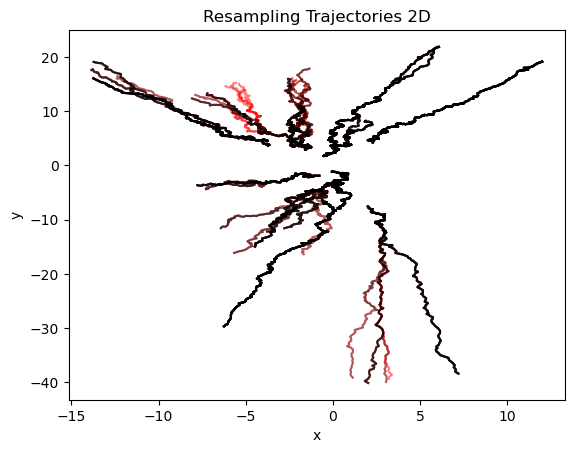

In [988]:
N_sample = 200
xs_sampled, idxs_sampled = sample_trajectory_xs_rectangle(Pi_est, xs_data, N_sample=N_sample)

print("A:", A, "\n", "A_est:", As[-1])
print("H:", H, "\n", "H_est", Hs[-1])
print("N_traj", process.N_traj)
# plot_trajectory1d(xs_data, ts_data, 0, show=False)
# [plot_trajectory1d(xs_sampled, ts_data, i, show=False, scatter=False) for i in range(N_sample)];

print("ts", ts_data[121])
# 1d trajectories
[plt.plot(ts_data, process.trajectories[i, :-1:downsample_rate, 0], alpha=0.5) for i in range(process.N_traj)];
[plt.plot(ts_data, xs_sampled[i, :, 0], color="black", alpha=0.3) for i in range(N_sample)];
plt.xlabel('time')
plt.ylabel('x')
plt.title("Resampling Trajectories")
for branch_time in branch_times_data:
    plt.axvline(ts_data[branch_time], color="red", alpha=0.3, label="branch times")
plt.show()

[plt.plot(process.trajectories[i, :-1:downsample_rate, 0], process.trajectories[i, :-1:downsample_rate, 1], alpha=0.5, color="red") for i in range(process.N_traj)];
[plt.plot(xs_sampled[i, :, 0], xs_sampled[i, :, 1], color="black", alpha=0.3) for i in range(N_sample)];
plt.xlabel('x')
plt.ylabel('y')
plt.title("Resampling Trajectories 2D")
plt.show()

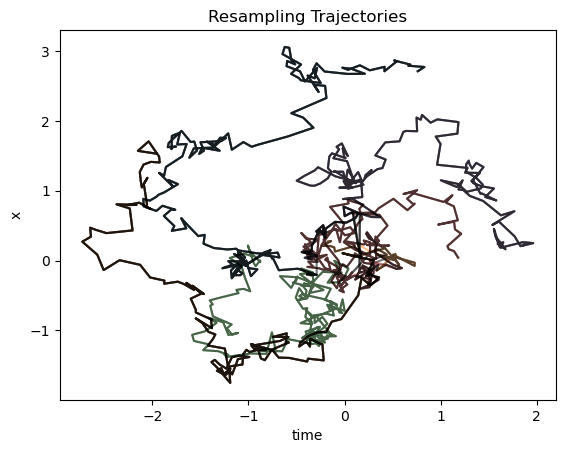

In [ ]:
[plt.plot(process.trajectories[i, :-1:downsample_rate, 0], process.trajectories[i, :-1:downsample_rate, 1], alpha=0.5) for i in range(process.N_traj)];
[plt.plot(xs_sampled[i, :, 0], xs_sampled[i, :, 1], color="black", alpha=0.3) for i in range(N_sample)];
plt.xlabel('x')
plt.ylabel('y')
plt.title("Resampling Trajectories 2D")
plt.show()

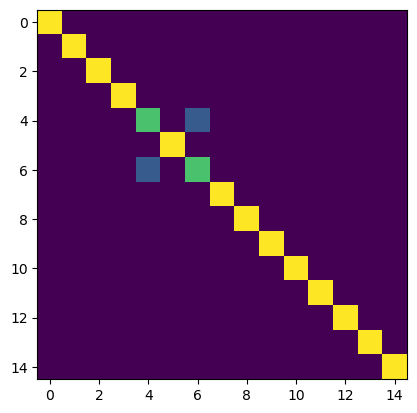

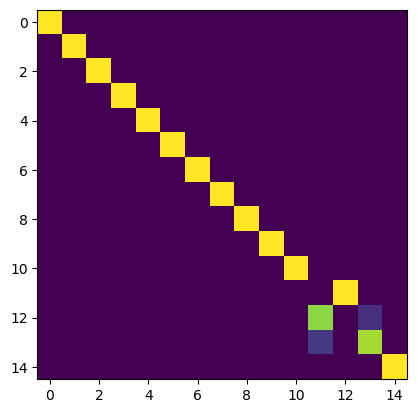

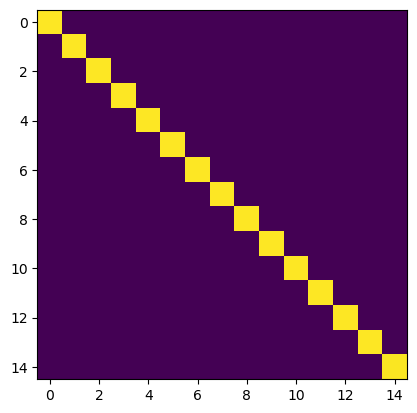

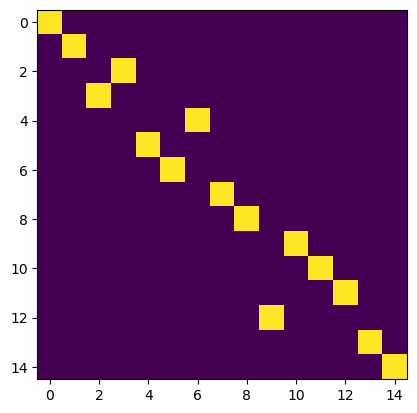

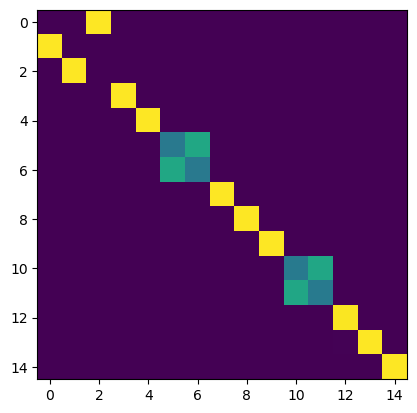

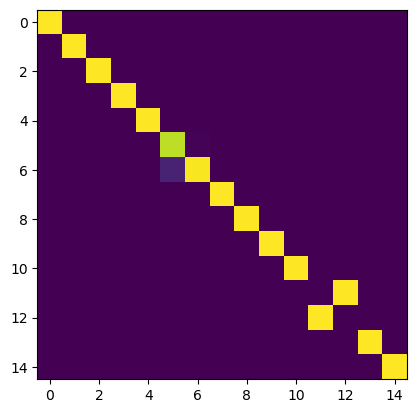

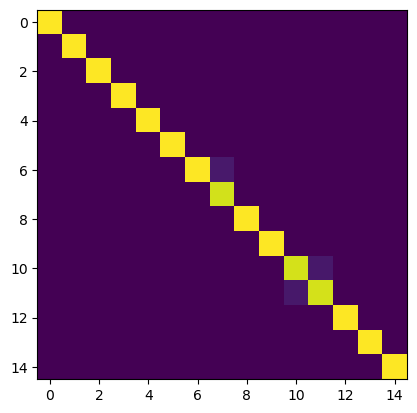

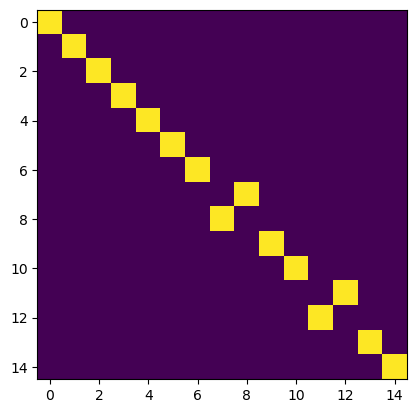

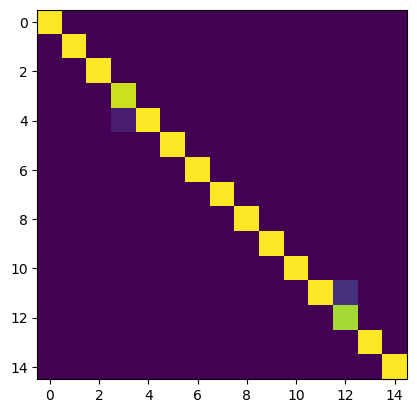

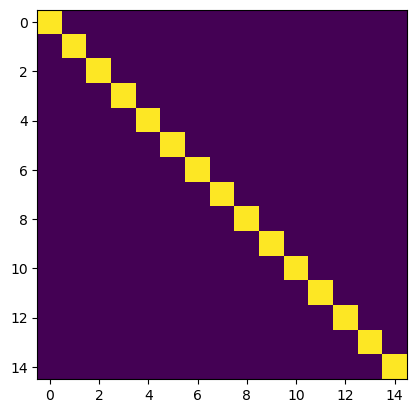

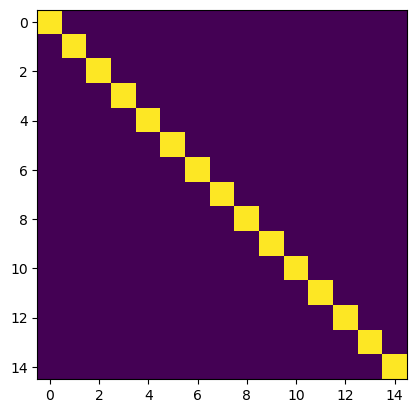

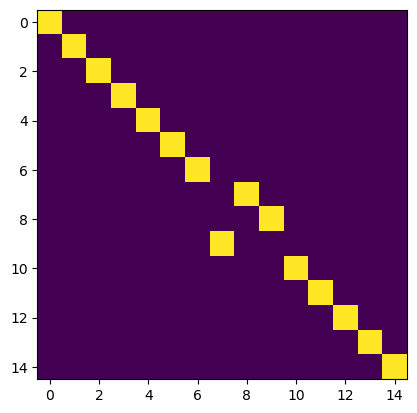

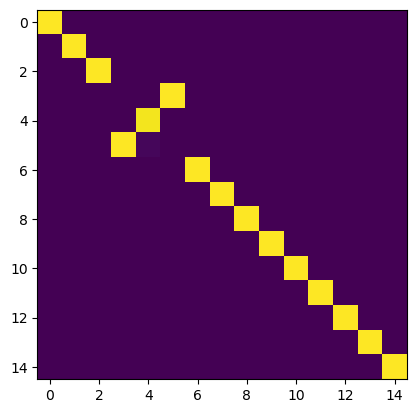

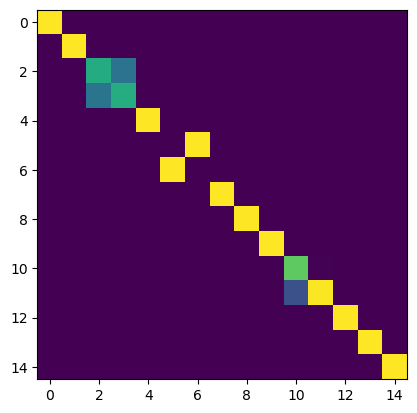

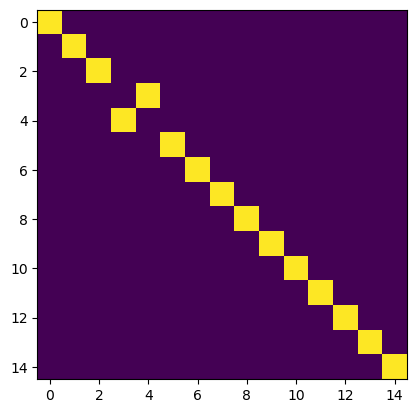

[(<matplotlib.image.AxesImage at 0x3720ad810>, None),
 (<matplotlib.image.AxesImage at 0x372120e80>, None),
 (<matplotlib.image.AxesImage at 0x3721a23b0>, None),
 (<matplotlib.image.AxesImage at 0x37221a3e0>, None),
 (<matplotlib.image.AxesImage at 0x37229a350>, None),
 (<matplotlib.image.AxesImage at 0x37231abc0>, None),
 (<matplotlib.image.AxesImage at 0x37239af20>, None),
 (<matplotlib.image.AxesImage at 0x372417820>, None),
 (<matplotlib.image.AxesImage at 0x3724936d0>, None),
 (<matplotlib.image.AxesImage at 0x372507760>, None),
 (<matplotlib.image.AxesImage at 0x37255e380>, None),
 (<matplotlib.image.AxesImage at 0x37261c610>, None),
 (<matplotlib.image.AxesImage at 0x37269cbe0>, None),
 (<matplotlib.image.AxesImage at 0x37271cc70>, None),
 (<matplotlib.image.AxesImage at 0x372795810>, None)]

In [204]:
[(plt.imshow(Pi_est[i]), plt.show()) for i in range(0, len(Pi_est), 100)]

A: [[ 0  2]
 [-2  0]] 
 A_est: [[-0.32411765  1.93265311]
 [-2.29634504 -0.08290651]]
H: [[1. 0.]
 [0. 1.]] 
 H_est [[1.0219854  0.00463828]
 [0.00463828 0.99782151]]
N_traj 15


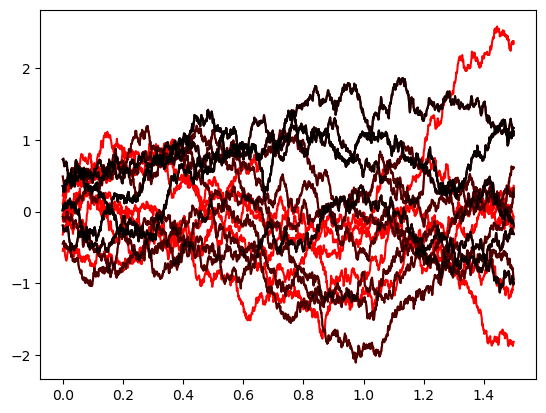

In [205]:
N_sample = 15
xs_sampled, idxs_sampled = sample_trajectory_xs_rectangle(Pi_est, xs_data, N_sample=N_sample)

print("A:", A, "\n", "A_est:", As[-1])
print("H:", H, "\n", "H_est", Hs[-1])
print("N_traj", process.N_traj)
# plot_trajectory1d(xs_data, ts_data, 0, show=False)
# [plot_trajectory1d(xs_sampled, ts_data, i, show=False, scatter=False) for i in range(N_sample)];


# 1d trajectories
[plt.plot(ts_data, process.trajectories[i, ::downsample_rate, 0], color="red", alpha=1) for i in range(process.N_traj)];
[plt.plot(ts_data, xs_sampled[i, :, 0], color="black", alpha=0.7) for i in range(N_sample)];
plt.show()
# 2d trajectories
# [plt.plot(xs_sampled[i, :, 0], xs_sampled[i, :, 1], color="red") for i in range(1)];
# [plt.plot(process.trajectories[i, ::downsample_rate, 0], process.trajectories[i, ::downsample_rate, 1]) for i in range(process.N_traj)];

# process.plot_trajectories(downsample=1)

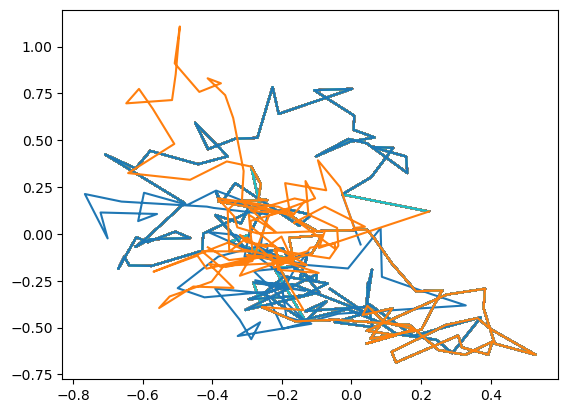

In [254]:
identity_couplings = np.array([np.eye(N_traj)]*(Nt - 1)) / N_traj

1500 15 2


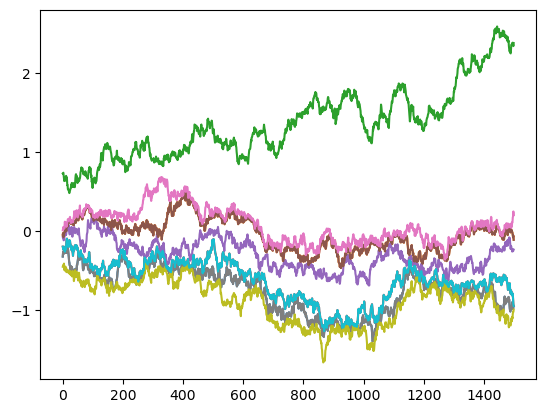

In [270]:
Nt, N_traj, d = np.array(xs_data).shape
print(Nt, N_traj, d)
# plt.plot(sample_trajectory_idxs_rectangle(identity_couplings, N_sample=10).T);
plt.plot(sample_trajectory_xs_rectangle(identity_couplings, xs_data, N_sample=10)[0][:, :, 0].T)

In [ ]:
plot_time_matrix(Pis[-1], 100)

AttributeError: 'list' object has no attribute 'shape'